# Inverse Problems

## Blur + Noise reconstruction

Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import equinox as eqx
import jax 
import jax.scipy as jsp
import jax.numpy as jnp
import helper as hlp
from tqdm import tqdm
import optax 
from functools import partial
%matplotlib inline
%load_ext autoreload
%autoreload 2

Working images 

- Version 1: without periodic padding

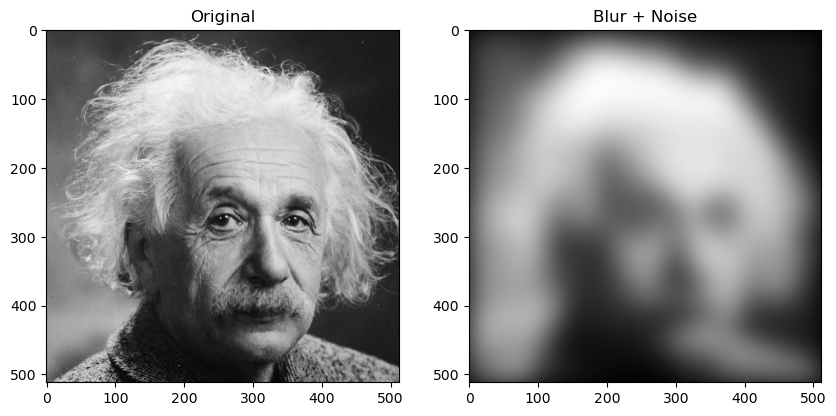

In [2]:
# original img 
img = ski.io.imread('data/img/einstein.tif').astype(np.float32)

# blurred and noisy img
gaussian_kernel = hlp.get_2D_Gaussian_kernel(20)
blur_img = jsp.signal.convolve(img,gaussian_kernel, mode='same')
np.random.seed(4)
gaussian_noise = np.random.normal(0, 1, img.shape)
blur_noise_img = blur_img + gaussian_noise
blur_noise_img= np.clip(blur_noise_img, 0,255)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
plt.show()

- Version 2: with periodic padding

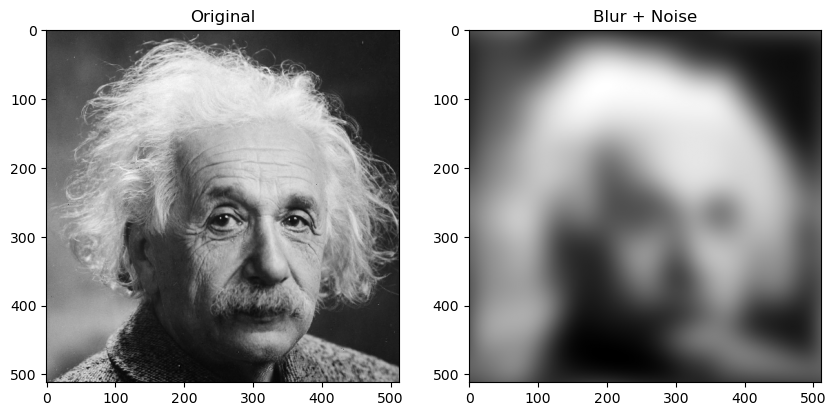

In [3]:
# original img 
img = ski.io.imread('data/img/einstein.tif').astype(np.float32)

# blurred and noisy img
gaussian_kernel = hlp.get_2D_Gaussian_kernel(20)

# perform convolution in Fourrier space
img_kernel = hlp.kernel_to_image(gaussian_kernel, img )
img_kernel_f = jnp.fft.fft2(img_kernel)
img_f = jnp.fft.fft2(img) 
blur_img_f = jnp.multiply(img_kernel_f, img_f)

# go back into space domain
blur_img = jnp.fft.ifft2(blur_img_f).real

# add noise
np.random.seed(4)
gaussian_noise = np.random.normal(0, 1, img.shape)
blur_noise_img = blur_img + gaussian_noise
blur_noise_img= np.clip(blur_noise_img, 0,255)

# plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize =(10,10))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_img, cmap= "gray")
ax2.set_title('Blur + Noise')
plt.show()

Reconstruction

- model 1: corresponding to version 1 without padding

In [4]:
class Model(eqx.Module):
    kernel: jnp.ndarray
    # y: jnp.ndarray

    def __init__(self, kernel):
        self.kernel = kernel
        # self.y = y

    def __call__(self, x):
        Ax = jsp.signal.convolve(x,self.kernel, mode='same') # this convolution don't have periodic condition boundary (for the convolution)
        return Ax
    

# loss function 
def loss(x, y, A): # not sure if it's better to put the loss inside the "Model" class
    loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return loss

# optimizer --> Proximal gradient descent
# @jax.jit  # passer loss en parametre static --> sinon jit fonctionne pas
@partial(jax.jit,  static_argnames=['loss'])
def optimizer_step(x, y, A, alpha, loss):  # alpha = learning rate
    loss_val, grads_val = jax.value_and_grad(loss)(x, y, A)
    # print(grads_val)
    
    # GD update
    x_new = x - alpha * grads_val

    # projection
    x_new = jnp.clip(x_new, 0, 255)

    return loss_val, x_new





In [ ]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 0.5
n_iter = 200 


losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha, loss) 
    losses.append(loss_val)

100%|██████████| 200/200 [04:53<00:00,  1.47s/it]


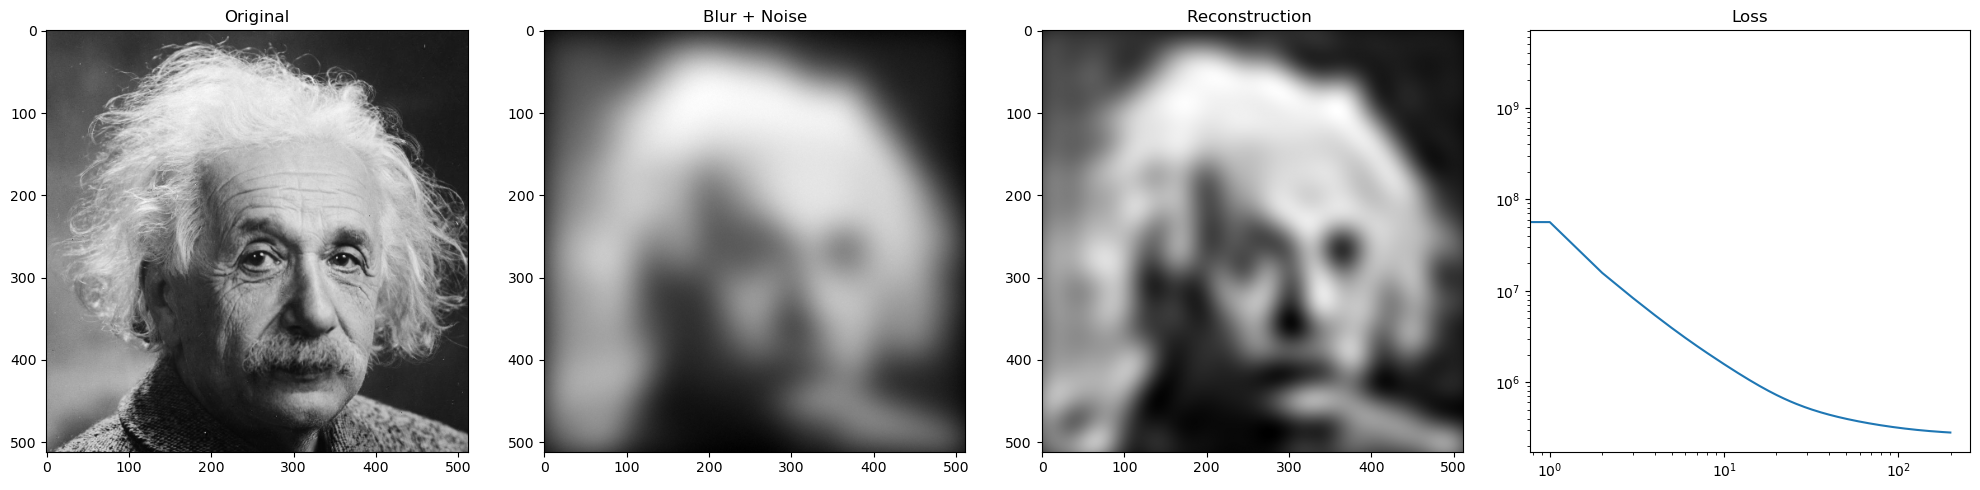

In [57]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

with ADAM optimizer

In [70]:
# optimization parameters
alpha = 7
n_iter = 300


# optimizer --> ADAM
ADAM_optimizer = optax.adam(learning_rate=alpha)

# @jax.jit ###############  checker pq je n'arrive pas 
def adam_optimizer_step(x, opt_state, loss):
    loss_val, grads_val = jax.value_and_grad(loss)(x, y, A)
    
    # ADAM update
    updates, opt_state = ADAM_optimizer.update(grads_val, opt_state)
    x = optax.apply_updates(x, updates)

    # projection
    # x_new = jnp.clip(x_new, 0, 255)

    return x, opt_state, loss_val


# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))
opt_state = ADAM_optimizer.init(x)

losses = []
# solve 
for _ in tqdm(range(n_iter)):
    x, opt_state, loss_val  = adam_optimizer_step(x, opt_state, loss) 
    losses.append(loss_val)

100%|██████████| 300/300 [08:40<00:00,  1.73s/it]


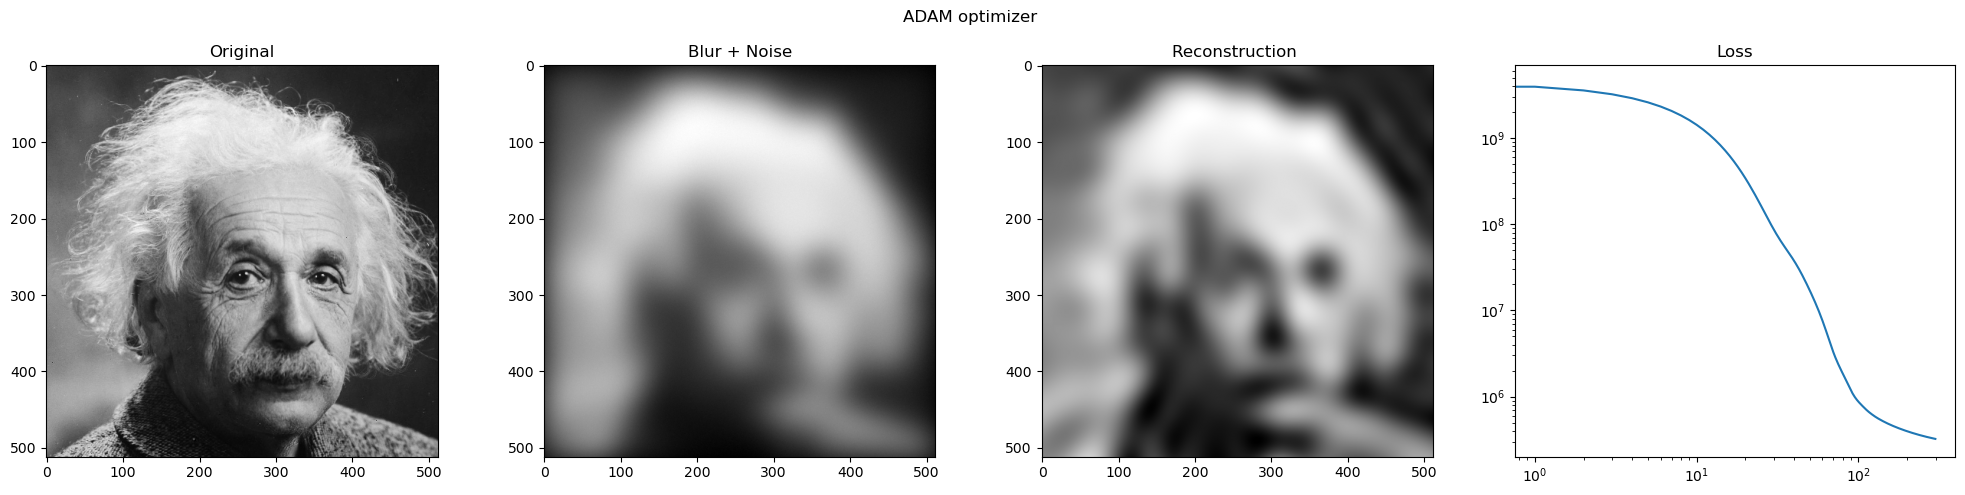

In [71]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('ADAM optimizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

- model 2: corresponding to version 2 with periodic padding

In [6]:
class Model_periodic_padding(eqx.Module):
    img_kernel_f: jnp.ndarray

    def __init__(self, img_kernel):
        self.img_kernel_f = jnp.fft.fft2(img_kernel)

    def __call__(self, x):
        # dft
        x_f = jnp.fft.fft2(x) 

        # filtering
        Ax_f = jnp.multiply(self.img_kernel_f, x_f)

        # go back into space domain
        Ax = jnp.fft.ifft2(Ax_f).real

        return Ax
    # loss and optimzer_step functions remain the same 

In [ ]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
L = jnp.max(jnp.abs(A.img_kernel_f))


# optimization parameters
alpha = 1/L
n_iter = 40000 
# n_iter = 10 



losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha, loss) 
    losses.append(loss_val)

In [26]:
losses[-1]

Array(59219404., dtype=float32)

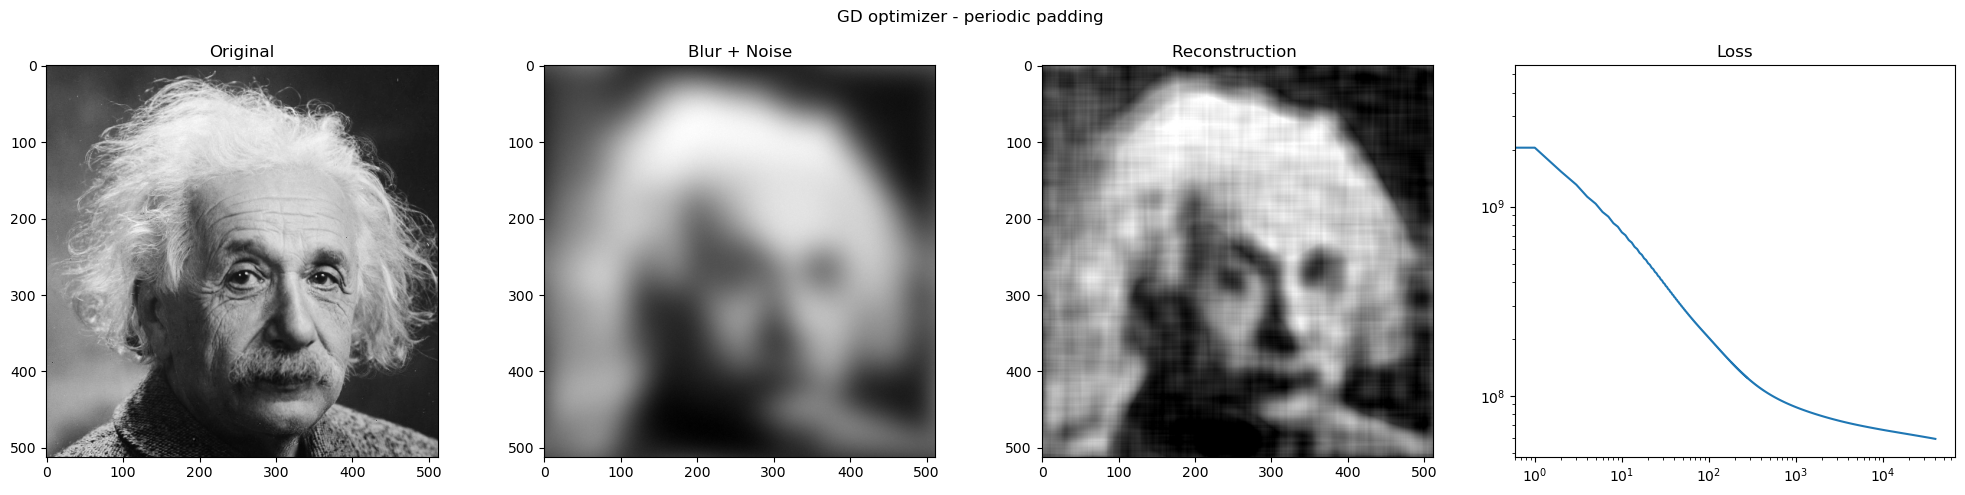

In [24]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('GD optimizer - periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

### With regulizer 

- L2: \norm{x}{2}^{2} model 1 (without periodic padding)

In [ ]:
# objectiv function : F(x) = f(x) g(x)
# the problem can be written as argmin{f(x) + g(x)} where f(x) = ||y-Ax||{2}^{2} and g(x) = ||x||{2}^{2}
# since g(x) = ||x||^2_2 (is smooth and convex), we can just use the same procedure than before by just adding g(x) to the loss function


# loss function 
def loss_rL2(x, y, A): # not sure if it's better to put the loss inside the "Model" class
    loss = jnp.linalg.norm(y-A(x), ord = 'fro')**2 + 0.1*jnp.linalg.norm(x)**2
    return loss

# initialisation 
x = jnp.zeros(img.shape) + 0.01 # doesn't work if i take 0 ############# find why
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))


# optimization parameters
alpha = 0.1
n_iter = 300 


losses = []
# solve 
for _ in tqdm(range(n_iter)):
    # print(x)
    loss_val, x = optimizer_step(x, y, A, alpha, loss_rL2) 
    losses.append(loss_val)

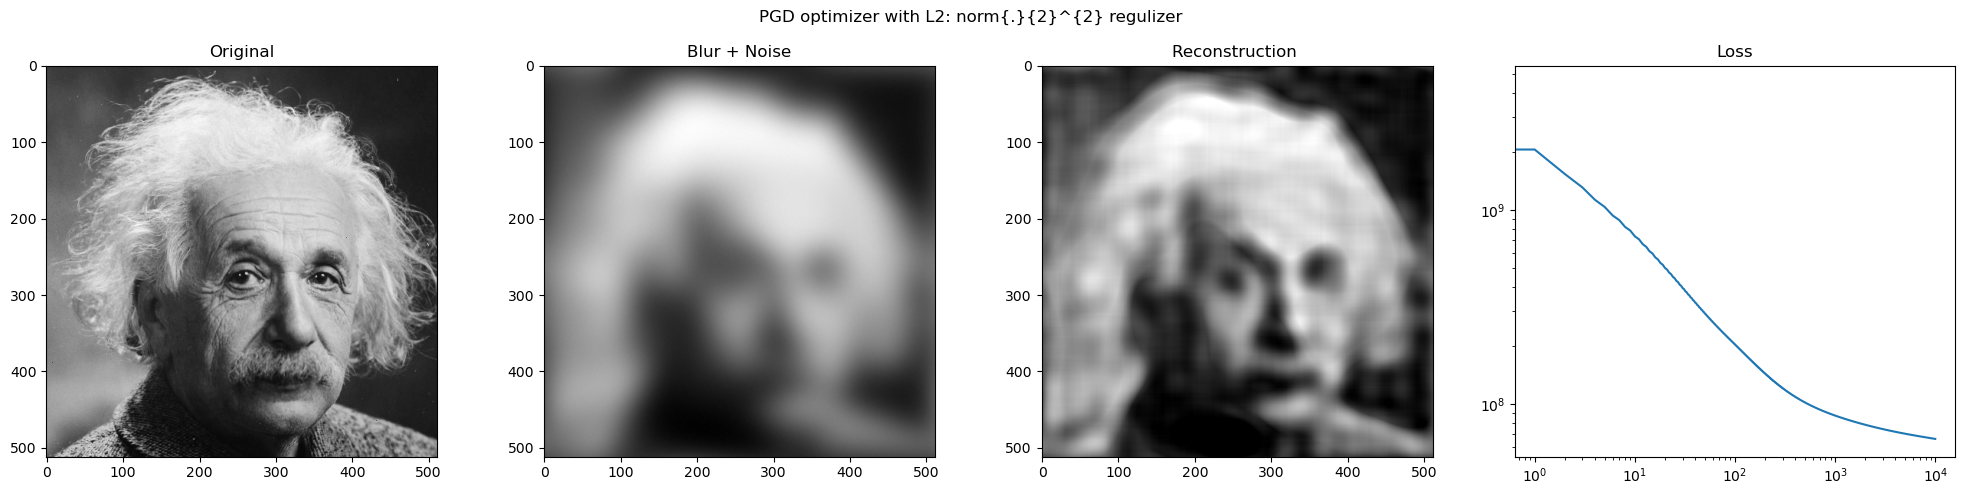

In [9]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L2: norm{.}{2}^{2} regulizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

- L2: \norm{x}{2}^{2}, model 2 (with periodic padding)

In [12]:
# initialisation 
x = jnp.zeros(img.shape) + 0.0001
y = jnp.array(blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
L = jnp.max(jnp.abs(A.img_kernel_f))


# optimization parameters
alpha = 0.01 # pas prendre 1/L car on a ajouté le regulizer dans la dérivée du loss, donc c'est plus ca, mais du coup, je sais pas comment trouver alpha, --> ou sinon j utilise le prox pour le regulizer
n_iter = 5000 
# n_iter = 10 



losses = []
# solve 
for _ in tqdm(range(n_iter)):
    loss_val, x = optimizer_step(x, y, A, alpha, loss_rL2) 
    losses.append(loss_val)

100%|██████████| 5000/5000 [00:50<00:00, 99.86it/s] 


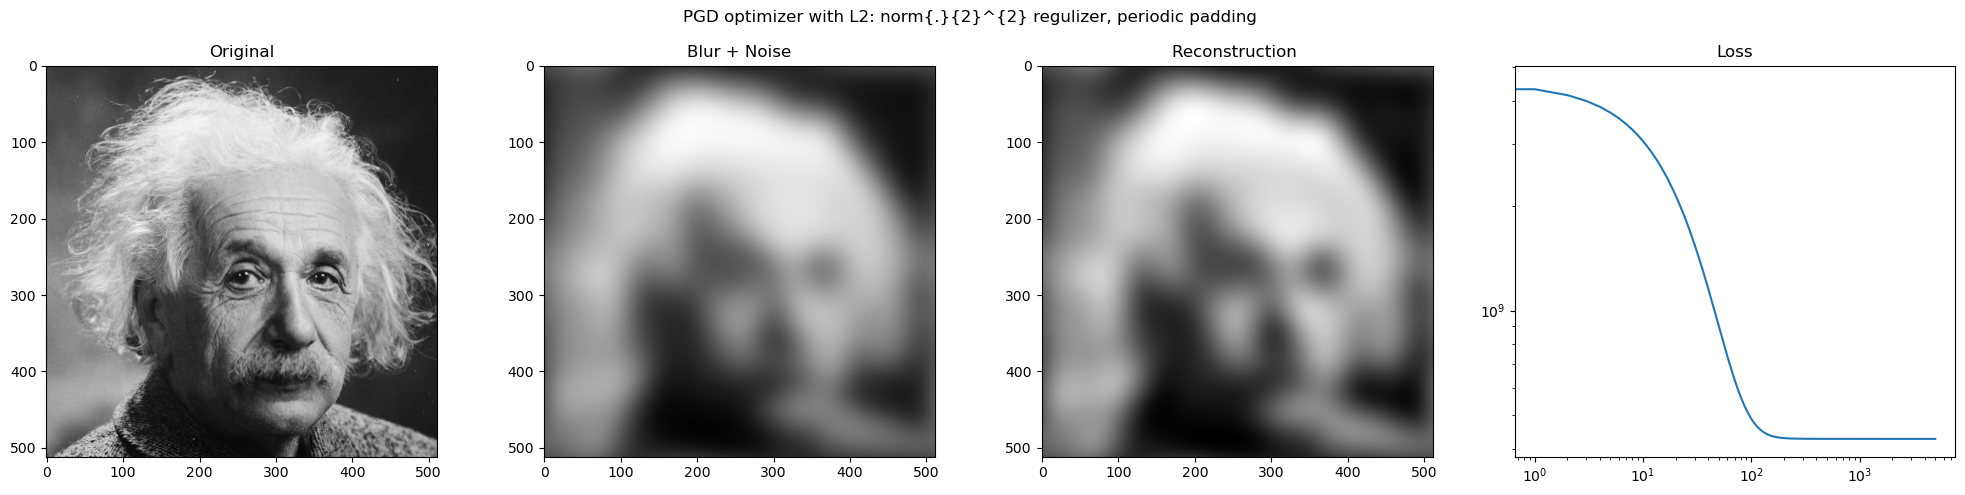

In [13]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L2: norm{.}{2}^{2} regulizer, periodic padding')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(losses)
ax4.set_title('Loss')
plt.tight_layout()
plt.show()

- L1: \Norm{x}{1}, model 1: without periodic padding

In [ ]:
# here g(x) = ||x||{1} is not smooth anymore. To solve inverse problem we use PGD with a proximal step
# loss function 
def f(x, y, A):
    fx = jnp.linalg.norm(y-A(x), ord = 'fro')**2
    return fx

def g(x):
    gx = jnp.sum(jnp.abs(x))
    return gx

# @jax.jit
def L1_optimizer_step(x, y, A, alpha, gamma):  # alpha = step size
    grads_val = jax.grad(f)(x, y, A)
    # print(grads_val)
    
    # GD update
    z = x - alpha * grads_val
    # print(z)
    # proximal step (soft threshold since is g(x) = ||x||{1})
    x_new = jnp.sign(z)*jnp.maximum(jnp.abs(z)-alpha, 0.0)
    # print(x_new)

    # projection
    # x_new = jnp.clip(x_new, 0, 255)
    
    # objectiv value 
    Fx_new = f(x_new,y, A) + g(x_new)
    return x_new, Fx_new

In [28]:
# init
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model(jnp.array(gaussian_kernel))
Fx_true = f(img, y, A) + g(img)
Fx_init = f(x, y, A) + g(x)
error = []
error.append(Fx_init-Fx_true)

# optimization parameters
alpha = 0.5
n_iter = 47 

# solve 
for _ in tqdm(range(n_iter)):
    x, Fx = L1_optimizer_step(x, y, A, alpha) 
    error.append(Fx-Fx_true)

NameError: name 'f' is not defined

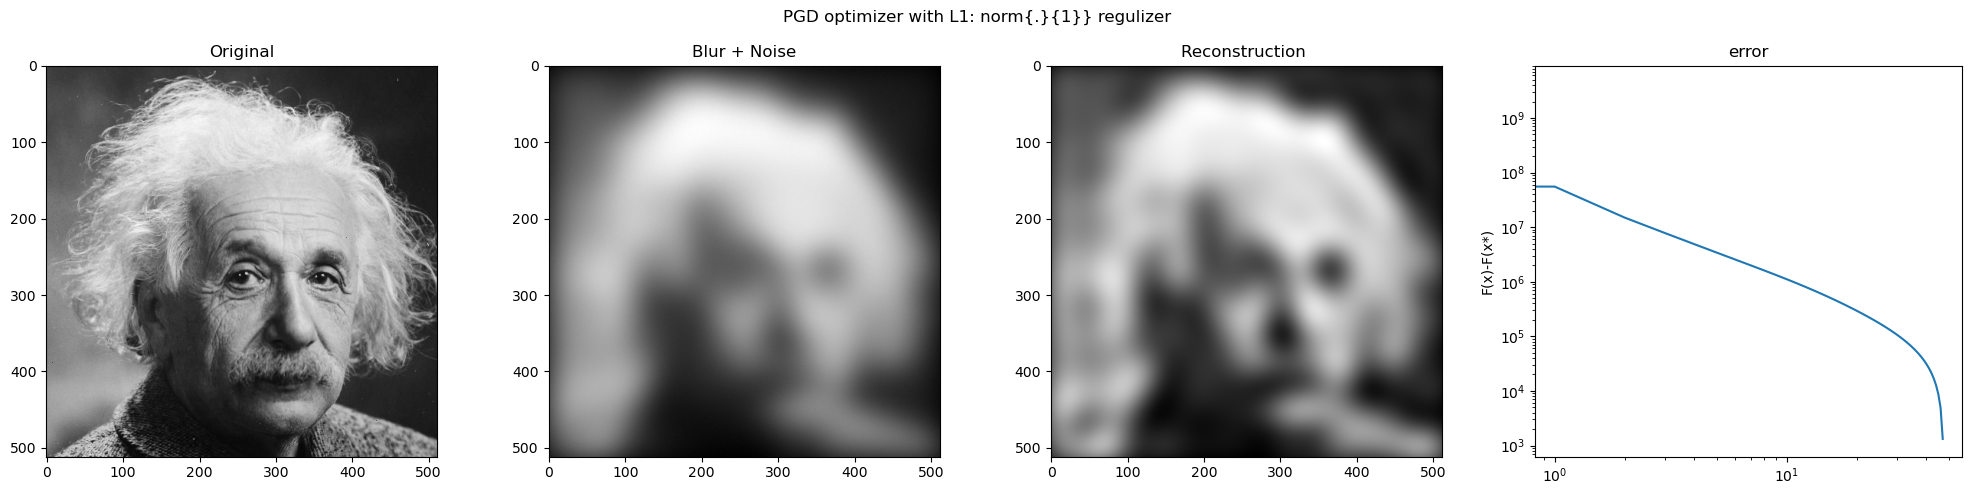

In [110]:
# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize =(20,5))
fig.suptitle('PGD optimizer with L1: norm{.}{1}} regulizer')
ax1.imshow(img, cmap= "gray")
ax1.set_title('Original')
ax2.imshow(blur_noise_img, cmap= "gray")
ax2.set_title('Blur + Noise')
ax3.imshow(x, cmap= "gray")
ax3.set_title('Reconstruction ')
ax4.loglog(error)
ax4.set_title('error')
ax4.set_ylabel('F(x)-F(x*)')
plt.tight_layout()
plt.show()

- L1: \Norm{x}{1}, model 2: with periodic padding

In [ ]:
# init
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
Fx_true = f(img, y, A) + g(img)
Fx_init = f(x, y, A) + g(x)
error = []
error.append(Fx_init-Fx_true)

# optimization parameters
alpha = 0.5
n_iter = 47 

# solve 
for _ in tqdm(range(n_iter)):
    x, Fx = L1_optimizer_step(x, y, A, alpha) 
    error.append(Fx-Fx_true)

Array(0.03646582, dtype=float32)

In [ ]:
# initialisation 
x = jnp.zeros(img.shape)
y = jnp.array(blur_noise_img)
A = Model_periodic_padding(jnp.array(img_kernel))
L = jnp.max(jnp.abs(A.img_kernel_f))
Fx_true = f(img, y, A) + g(img)
Fx_init = f(x, y, A) + g(x)
error = []
error.append(Fx_init-Fx_true)



# optimization parameters
alpha = 0.5
n_iter = 47 

# solve 
for _ in tqdm(range(n_iter)):
    x, Fx = L1_optimizer_step(x, y, A, alpha) 
    error.append(Fx-Fx_true)

In [ ]:
# alpha : step size = 1/L (si j'arrive à trouver L) --> pourrait se trouver en prenant transfo de fourrier du kernel puis prendre le max
# lambda : facteur amplifiant la sparsité 
# tau : threshold = alpha*lambda 

# faire ca, pour L--> regarder slide img proc 1 dernier chap

#chnager l1 -->ajouter en parametre lambda pour prendre en compte le facteur d intensité et le treshold 